In [3843]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# 1-EDA

## A-TRAIN DATA

In [3844]:
train=pd.read_csv('./datasets/train.csv')

In [3845]:
train.shape

(2051, 81)

In [3846]:
(train.isnull().sum()/len(train.index)).sort_values(ascending=False).head(10)


Pool QC          0.995612
Misc Feature     0.968308
Alley            0.931741
Fence            0.804973
Fireplace Qu     0.487567
Lot Frontage     0.160897
Garage Finish    0.055583
Garage Cond      0.055583
Garage Qual      0.055583
Garage Yr Blt    0.055583
dtype: float64

In [3847]:
# first 5 variables are dropped because of insufficient data. Kurd gave the idea to me.
train.drop(columns=['Pool QC','Misc Feature','Alley','Fence','Fireplace Qu'],inplace=True)

In [3848]:
train.shape

(2051, 76)

### change type of the years' to string
Beathany warned me to avoid from dummy issues if i will use year in model

In [3849]:
# a=train.columns[train.isna().any()].tolist()
# a

# Paul slack to me

In [3850]:
for i in train.columns:
    if ('Year' in i) or ('Yr' in i):
        print(i)
        
#i for i in train.columns if 'Yr' in i

Year Built
Year Remod/Add
Garage Yr Blt
Yr Sold


In [3851]:
# l=[1895, 1896, 1900, 1910, 1914]
year_change_dict={ '1870s':[1870, 1879], '1880s':[1880, 1989],
                    '1890s':[1890, 1899], '1900s':[1900, 1909],  '1910s':[1910, 1919],
                  '1920s':[1920, 1929], '1930s':[1930, 1939],  '1940s':[1940, 1949],
                  '1950s':[1950, 1959], '1960s':[1960, 1969],  '1970s':[1970, 1979],
                  '1980s':[1980, 1989], '1990s':[1990, 1999],  '2000s':[2000, 2009],
                  '2010s':[2010, 2019], '2200s':[2020,3000 ]  
                  }

def age_maker(value, dict_years=year_change_dict):
        for k, v in year_change_dict.items():
            if (value>=v[0] and value<=v[1]):
                return(k)
            elif value=='NaN':
                return('unknown')# if year is null so it will return to string as 'unknown'

In [3852]:
# Bethany make a favor: thnx for codes
train['Garage Yr Blt_category']=train['Garage Yr Blt'].apply(lambda x: age_maker(x))
train['Year Built_category']=train['Year Built'].apply(lambda i: age_maker(i))
train['Year Remod/Add_category']=train['Year Remod/Add'].apply(lambda i: age_maker(i))
train['Yr Sold_category']=train['Yr Sold'].astype(str)

# train['Id']=train['Id'].astype(str)
# train['PID']=train['PID'].astype(str)


In [3853]:
train.shape

(2051, 80)

### Find out the Null Cells and fit them 

In [3854]:
null_cols=train.isnull().sum().sort_values(ascending=False)
null_cols = null_cols[null_cols>0]
null_cols.head(5)

Lot Frontage              330
Garage Yr Blt_category    114
Garage Yr Blt             114
Garage Finish             114
Garage Qual               114
dtype: int64

In [3855]:

null_cols=list(null_cols.index)

f_cols =train.select_dtypes(include=float)
i_cols =train.select_dtypes(include=int)
numeric_cols=list(f_cols+i_cols)

null_num_cols=list()
for i in null_cols:
    if i in numeric_cols:
        null_num_cols.append(i)
print(f'numeric columns: {null_num_cols}\n')

null_object_cols= [i for i  in null_cols if i not in null_num_cols]
print(f'object  columns: {null_object_cols}')

numeric columns: ['Lot Frontage', 'Garage Yr Blt', 'Mas Vnr Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Area', 'Garage Cars', 'Total Bsmt SF', 'Bsmt Unf SF', 'BsmtFin SF 2', 'BsmtFin SF 1']

object  columns: ['Garage Yr Blt_category', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Garage Type', 'Bsmt Exposure', 'BsmtFin Type 2', 'Bsmt Cond', 'BsmtFin Type 1', 'Bsmt Qual', 'Mas Vnr Type']


In [3856]:
len(train.columns)

80

In [3857]:
train['Lot Frontage'].fillna(np.sqrt(train['Lot Area']), inplace=True) # Bethany and Kurd helped for this
# train['Garage Yr Blt'].fillna(0, inplace=True) #114 rows  // converted to string
train['Mas Vnr Area'].fillna(train['Mas Vnr Area'].mean(), inplace=True) # 22 rows
train['Bsmt Full Bath'].fillna(0, inplace=True) # 2 rows
train['Bsmt Half Bath'].fillna(0, inplace=True) # 2 rows
train['BsmtFin SF 2'].fillna(np.mean(train['BsmtFin SF 2']), inplace=True) # 1 row
train['BsmtFin SF 1'].fillna(np.mean(train['BsmtFin SF 1']), inplace=True) # 1 row
train['Total Bsmt SF'].fillna(np.mean(train['Total Bsmt SF']), inplace=True) # 1 row
train['Bsmt Unf SF'].fillna(np.mean(train['Bsmt Unf SF']), inplace=True) # 1 row
train['Garage Cars'].fillna(0, inplace=True) # 1 row
train['Garage Area'].fillna(np.mean(train['Garage Area']), inplace=True) # 1 row

for i in null_object_cols:
    train[i].fillna('unknown', inplace=True)

In [3858]:
train.isnull().sum().sort_values(ascending=False).head()

Garage Yr Blt     114
Total Bsmt SF       0
Year Remod/Add      0
Roof Style          0
Roof Matl           0
dtype: int64

In [3859]:
train[train['PID']==527165230]

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
23  12  527165230           20        RL     89.330846      7980   Pave   

   Lot Shape Land Contour Utilities        ...        Pool Area Misc Val  \
23       IR1          Lvl    AllPub        ...                0      500   

   Mo Sold Yr Sold Sale Type SalePrice Garage Yr Blt_category  \
23       3    2010       WD     185000                  1990s   

    Year Built_category  Year Remod/Add_category  Yr Sold_category  
23                1990s                    2000s              2010  

[1 rows x 80 columns]

In [3860]:
# Michael slacked this code to me!

# column_dic = {}

# for i in list(train.select_dtypes(include=['object']).columns):
#     column_dic[i] = {"Nuls" : train[i].isnull().sum(),
#                     "Type": train[i].dtypes,
#                     "Values": train[i].value_counts(dropna = False)}

# for i in column_dic:
#     print(i)
#     print(column_dic[i]["Values"])
#     print("\n")

In [3861]:
# train[train['Neighborhood']=='Greens']
# train[train['Neighborhood']=='Greens']['Lot Area']
# train.groupby(['Neighborhood'])['Lot Frontage'].mean()

### Drop numeric year columns- i added year's string fromat to data above

In [3862]:
train=train.drop(columns=['Year Built','Year Remod/Add','Garage Yr Blt','Yr Sold'])
train.shape

(2051, 76)

### get dummies

In [3863]:
train = pd.get_dummies(train)
train.shape

(2051, 298)

## B-TEST DATA

In [3864]:
target=pd.read_csv('./datasets/test.csv')

target.shape

(879, 80)

In [3865]:
(target.isnull().sum()/len(target.index)).sort_values(ascending=False).head(5)

Pool QC         0.995449
Misc Feature    0.953356
Alley           0.934016
Fence           0.804323
Fireplace Qu    0.480091
dtype: float64

In [3866]:
target.drop(columns=['Pool QC','Misc Feature','Alley','Fence','Fireplace Qu'],inplace=True)

target.shape

(879, 75)

In [3867]:
null_cols=target.isnull().sum().sort_values(ascending=False)
null_cols = null_cols[null_cols>0]
null_cols.head()

Lot Frontage     160
Garage Qual       45
Garage Cond       45
Garage Yr Blt     45
Garage Finish     45
dtype: int64

In [3868]:
for i in target.columns:
    if ('Year' in i) or ('Yr' in i):
        print(i)
        

Year Built
Year Remod/Add
Garage Yr Blt
Yr Sold


In [3869]:
''' Converting the numeric years into text'''
# Bethany make a favor by coding it

target['Garage Yr Blt_category']=target['Garage Yr Blt'].apply(lambda x: age_maker(x))
target['Year Built_category']=target['Year Built'].apply(lambda i: age_maker(i))
target['Year Remod/Add_category']=target['Year Remod/Add'].apply(lambda i: age_maker(i))
target['Yr Sold_category']=target['Yr Sold'].astype(str)

target.shape

(879, 79)

In [3870]:
target=target.drop(columns=['Year Built','Year Remod/Add','Garage Yr Blt','Yr Sold'])
target.shape

(879, 75)

In [3871]:
### Find out the Null Cells and fill them 

target.isnull().sum().sort_values(ascending=False).head(5)

null_cols=target.isnull().sum().sort_values(ascending=False)
null_cols = null_cols[null_cols>0]

null_cols=list(null_cols.index)

f_cols =target.select_dtypes(include=float)
i_cols =target.select_dtypes(include=int)
numeric_cols=list(f_cols+i_cols)

null_num_cols=list()
for i in null_cols:
    if i in numeric_cols:
        null_num_cols.append(i)
print(f'null numeric columns: {null_num_cols}\n')

null_object_cols= [i for i  in null_cols if i not in null_num_cols]
print(f'null object  columns: {null_object_cols}')

target['Lot Frontage'].fillna(np.sqrt(target['Lot Area']), inplace=True) # 160 rows 
target['Mas Vnr Area'].fillna(target['Mas Vnr Area'].mean(), inplace=True) # 1 row

null numeric columns: ['Lot Frontage', 'Mas Vnr Area']

null object  columns: ['Garage Finish', 'Garage Yr Blt_category', 'Garage Qual', 'Garage Cond', 'Garage Type', 'BsmtFin Type 1', 'Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual', 'BsmtFin Type 2', 'Mas Vnr Type', 'Electrical']


In [3872]:
for i in null_object_cols:
    target[i].fillna('unknown', inplace=True)

target.isnull().sum().sum()

0

In [3873]:
target = pd.get_dummies(target)
target.shape

(879, 282)

In [3874]:
c=list(train.columns) #corr_predictors
d=list(target.columns)
intersect_cols=np.intersect1d(c,d)
c_d=list(set(c)-set(d))
d_c=list(set(d)-set(c))

set(target.columns)-set(X)

print(f'train cols:{len(c)} \ntest cols:{len(d)}\nintersect:{len(np.intersect1d(c,d))}\ntrain-test:{len(c_d)}\ntest-train:{len(d_c)}')

train cols:298 
test cols:282
intersect:272
train-test:26
test-train:10


In [3875]:
add2train=pd.DataFrame(0,range(0,2051),d_c)
add2train.shape

add2test=pd.DataFrame(0,range(0,879),c_d)
add2test.shape

train=pd.merge(train,add2train,left_on=train.index,right_on=add2train.index, how='inner',suffixes=(False, False))
train.shape

target=pd.merge(target, add2test, left_on=target.index, right_on=add2test.index, how='inner',suffixes=(False, False))
target.shape

(879, 309)

In [3876]:
target=target.drop(columns='key_0')
target.shape

(879, 308)

In [3877]:
train=train.drop(columns='key_0')
train.shape

(2051, 308)

In [3878]:
# l=[]
# for i in d:
#     if i in c:
#         l.append(i)
# print(len(l))


In [3879]:
'Id' in target.columns

True

# 2-FEATURES

In [3880]:
subtrac_list=['SalePrice','PID','Id','key_0']
# 'Enclosed Porch', 'Kitchen AbvGr', 'Overall Cond', 'MS SubClass','Bsmt Half Bath', 'Low Qual Fin SF', '3Ssn Porch'

# predictors = numeric_cols.remove(subtrac_list) ??? Why didnt work
predictors = [e for e in numeric_cols if e not in subtrac_list]
len(predictors)

32

In [3881]:
corr_predictors=[i for i in corr_list if i not in subtrac_list]
len(corr_predictors)

305

In [3882]:
alternative_features=['Overall Qual','Gr Liv Area','Garage Area','Garage Cars','Total Bsmt SF','1st Flr SF',
 'Bsmt Qual_Ex','Kitchen Qual_Ex','Full Bath','Foundation_PConc','Year Built_category_2000s','Mas Vnr Area',
 'Garage Yr Blt_category_2000s','TotRms AbvGrd','Exter Qual_Ex','Fireplaces','BsmtFin Type 1_GLQ','Heating QC_Ex',
 'Neighborhood_NridgHt','Exter Qual_Gd','Year Remod/Add_category_2000s','BsmtFin SF 1','Garage Finish_Fin',
 'Bsmt Exposure_Gd','Sale Type_New','Garage Type_Attchd','Exterior 1st_VinylSd','Exterior 2nd_VinylSd','Open Porch SF',
 'Wood Deck SF','Mas Vnr Type_Stone','Kitchen Qual_Gd','Lot Area','Lot Frontage','Paved Drive_Y','Bsmt Full Bath',
 'Exter Qual_TA', 'Year Built_category_1880s', 'Kitchen Qual_TA','Year Remod/Add_category_1880s', 'Bsmt Qual_TA',
 'Garage Yr Blt_category_1880s', 'Garage Finish_Unf','Mas Vnr Type_None', 'Garage Type_Detchd', 'Foundation_CBlock']

features=corr_predictors  # used in the Method
X=train[features]
y=train['SalePrice']

In [3883]:
X.shape

(2051, 305)

In [3884]:
len(set(train.columns)-set(features))

3

## HEATMAP

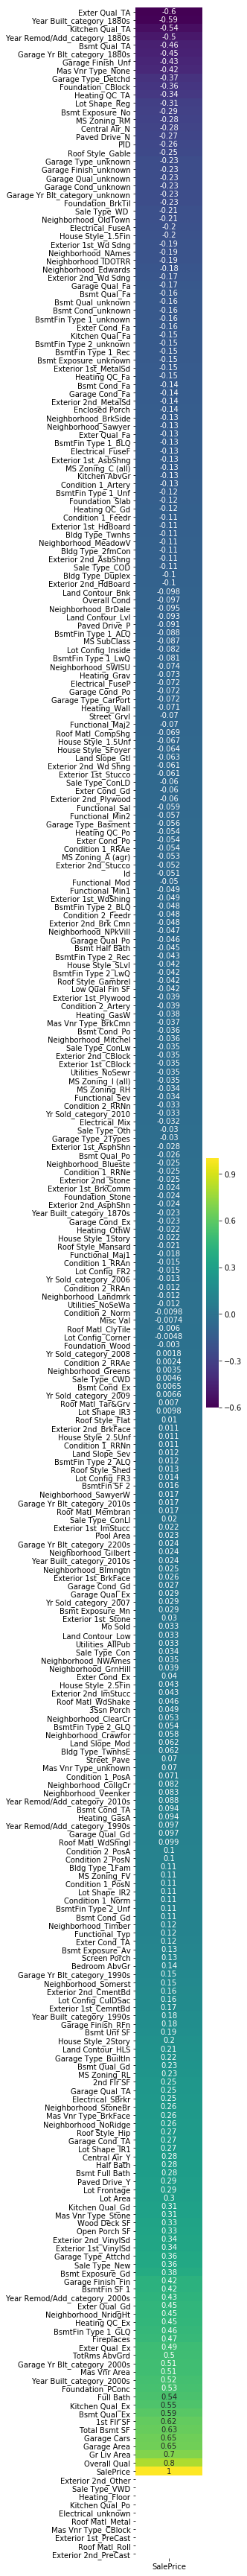

In [3885]:
plt.figure(figsize=(2,63))
heatmap=sns.heatmap(train.corr()[['SalePrice']].sort_values('SalePrice'), annot=True, cmap='viridis')
heatmap

In [3886]:
# corr_list=train.corr().sort_values('SalePrice').index
# list(corr_list)[::-1]

In [3887]:
# mask=target.filter(items=['Id','Overall Qual','Gr Liv Area','Garage Area','Exter Qual_TA'])

# target.ix[[778,850,33,127,339],['Id','Overall Qual','Gr Liv Area','Garage Area','Garage Cars',
#  'Total Bsmt SF',
#  '1st Flr SF',
#  'Bsmt Qual_Ex',
#  'Kitchen Qual_Ex',
#  'Full Bath',
#  'Foundation_PConc',
#  'Year Built_category_2000s',
#  'Mas Vnr Area',
#  'Garage Yr Blt_category_2000s',
#  'TotRms AbvGrd',
#  'Exter Qual_Ex',
#  'Fireplaces',
#  'BsmtFin Type 1_GLQ',
#  'Heating QC_Ex',
#  'Neighborhood_NridgHt',
#  'Exter Qual_Gd',
#  'Year Remod/Add_category_2000s',
#  'BsmtFin SF 1',
#  'Garage Finish_Fin',
#  'Bsmt Exposure_Gd',
#  'Sale Type_New',
#  'Garage Type_Attchd',
#  'Exterior 1st_VinylSd',
#  'Exterior 2nd_VinylSd',
#  'Open Porch SF',
#  'Wood Deck SF',
#  'Mas Vnr Type_Stone',
#  'Kitchen Qual_Gd',
#  'Lot Area',
#  'Lot Frontage',
#  'Paved Drive_Y',
#  'Bsmt Full Bath',
# 'Exter Qual_TA', 'Year Built_category_1880s', 'Kitchen Qual_TA',
#        'Year Remod/Add_category_1880s', 'Bsmt Qual_TA',
#        'Garage Yr Blt_category_1880s', 'Garage Finish_Unf',
#        'Mas Vnr Type_None', 'Garage Type_Detchd', 'Foundation_CBlock']]

 

## PAIRPLOT

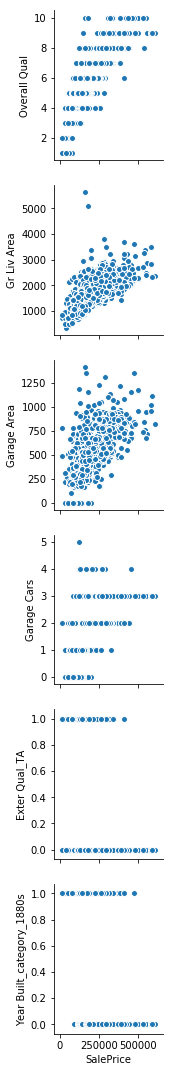

In [3888]:
sns.pairplot(train, y_vars=['Overall Qual','Gr Liv Area', 'Garage Area', 'Garage Cars','Exter Qual_TA','Year Built_category_1880s'], x_vars=['SalePrice'])

# 3- MODELS

## A-MLR

In [3889]:
linModel=LinearRegression()
linModel.fit(X,y)
# prediction1=linModel.predict(X)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## splitting

In [3890]:
X_train,X_test,y_train,y_test=train_test_split(X,y, random_state=42)

In [3891]:
X_train.shape

(1538, 305)

In [3892]:
linModel.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [3893]:
linModel.score(X_train,y_train)

0.931218088833676

In [3894]:
linModel.score(X_test,y_test)

0.912081693899648

## B- LASSO 

In [3895]:
ss = StandardScaler()
ss.fit(X_train) # Learning mean and std for every column

X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test) # must we transform test varaibles????

In [3896]:
lasso = LassoCV(cv=5)

lasso.fit(X_train_scaled,y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [3897]:
lasso.score(X_train_scaled,y_train)

0.9226665075615219

In [3898]:
lasso.score(X_test_scaled,y_test)

0.9204910606444002

In [3899]:
lasso_scores.mean() # cross_val_score

0.6333705982875941

### try for whole train data ?

In [3900]:

# X_sc=ss.transform(X)

# lasso.predict(X)

# lasso.score(X_sc,y)

## C-RIDGE


I have above ss and transformed X_train which are created for Lasso Model. i can use them here for ridge as well

In [3901]:
ridge= RidgeCV(cv=5)

ridge.fit(X_train_scaled,y_train)

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=5, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [3902]:
ridge.score(X_train_scaled,y_train)

0.9311724976521785

In [3903]:
ridge.score(X_test_scaled,y_test)

0.9123057376428262

In [3904]:
ridge_scores.mean()  # cross_val_score

0.8340220384956336

In [3905]:
len(ridge.coef_)

305

### Graph of Features

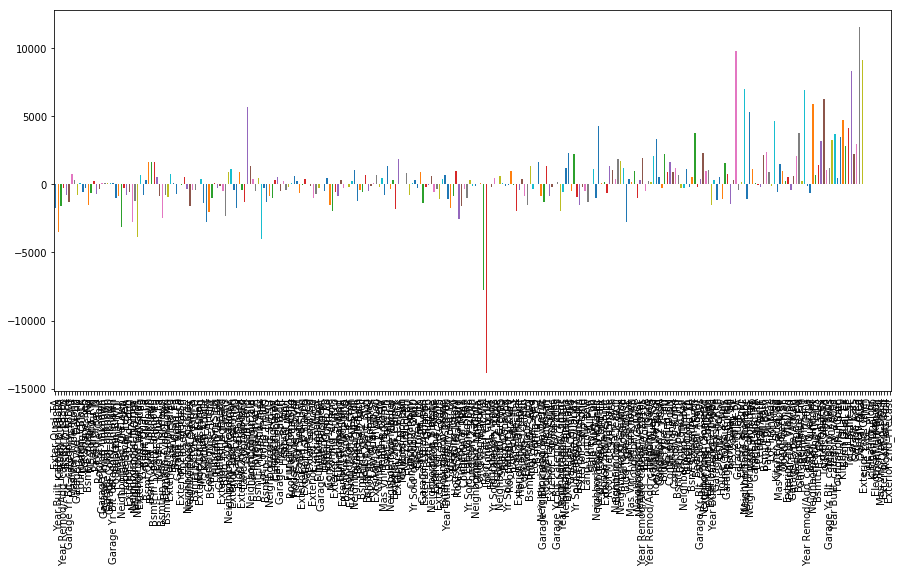

In [3906]:
pd.Series(ridge.coef_ , index=features).plot.bar(figsize=(15, 7))

### try for whole train data ?

In [3907]:
#ridge.score(X_sc,y)

## D-Comparision of 3 Models

#### cross val scores

In [3908]:
lin_scores=cross_val_score(linModel,X_train,y_train, cv=5).mean()
lasso_scores=cross_val_score(lasso, X_train,y_train, cv=5).mean()
ridge_scores=cross_val_score(ridge, X_train,y_train, cv=5).mean()

print(f'linear: {round(lin_scores,2)} \n lasso: {round(lasso_scores,2)} \n ridge: {round(ridge_scores,2)} ')

linear: 0.81 
 lasso: 0.63 
 ridge: 0.83 


####  After Fitting Scores

In [3909]:
a=linModel.score(X_test,y_test)
b=lasso.score(X_test_scaled,y_test)
c=ridge.score(X_test_scaled, y_test)
print(f'linear: {round(a,2)} \n lasso: {round(b,2)} \n ridge:{round(c,2)} ')

linear: 0.91 
 lasso: 0.92 
 ridge:0.91 


#### comparison of MSE of Models

In [3910]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

a=mean_squared_error(Predict_lin,y_test)
b=mean_squared_error(Predict_lasso,y_test)
c=mean_squared_error(Predict_ridge,y_test)

print(f'linear: {a} \n lasso: {b} \n ridge:{c} ')

linear: 539820573.7032075 
 lasso: 488186853.9241738 
 ridge:538444939.5794212 


### Predictions of Models

In [3911]:
Predict_lin=linModel.predict(X_test)
Predict_lasso=lasso.predict(X_test_scaled)
Predict_ridge=ridge.predict(X_test_scaled)

# 4-CHOOSE THE MODEL

###  lasso is giving best result. 

In [3912]:
target.shape

(879, 308)

In [3913]:
X_target=target[features]
X_target_sc=ss.transform(X_target)
X_target_sc.shape

(879, 305)

#### QUESTION ?
in this step shall i fit the lasso  as lasso.fit(X_target) or no need to do this? at above cells i fitted lasso
after creating splitted tarin data.so can I think my lasso model knows the data(so i have a lasso equation)  and in this step no need to identify data to lasso  second time.? 

In [3914]:
# dict(target[target.index==778])

In [3915]:
target['SalePrice']=lasso.predict(X_target_sc)
target['SalePrice'].describe()

count       879.000000
mean     179655.289062
std       74542.573173
min      -30053.173460
25%      129045.660468
50%      161766.086022
75%      213876.966481
max      593980.918188
Name: SalePrice, dtype: float64

In [3916]:
train['SalePrice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

In [3917]:
# Lin_X=target[features]
# Lin_X.shape

In [3918]:
# target['SalePrice']=linModel.predict(Lin_X)
# target['SalePrice'].sort_values(ascending=True).mean()

In [3919]:
# target['SalePrice']=ridge.predict(target_sc)
# target['SalePrice'].sort_values(ascending=True).mean()

# 5-  SUBMIT

In [3920]:
submission=target[['Id','SalePrice']]
submission.mean()

Id             1445.588168
SalePrice    179655.289062
dtype: float64

In [3921]:
submission.to_csv('./datasets/submission.csv', index=False)

In [3922]:
submission.describe()

Id      SalePrice
count   879.000000     879.000000
mean   1445.588168  179655.289062
std     850.717105   74542.573173
min       2.000000  -30053.173460
25%     692.500000  129045.660468
50%    1435.000000  161766.086022
75%    2197.000000  213876.966481
max    2928.000000  593980.918188

# GRAPHS

In [3923]:
residual=Predict_lasso-y_test
table=pd.DataFrame(residual)
table.rename(columns={'SalePrice':'residual'}, inplace=True)
table.describe()

residual
count     513.000000
mean     1528.085697
std     22063.561302
min   -106073.729211
25%     -8935.108420
50%      1255.847330
75%     12597.137034
max    112923.982560

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


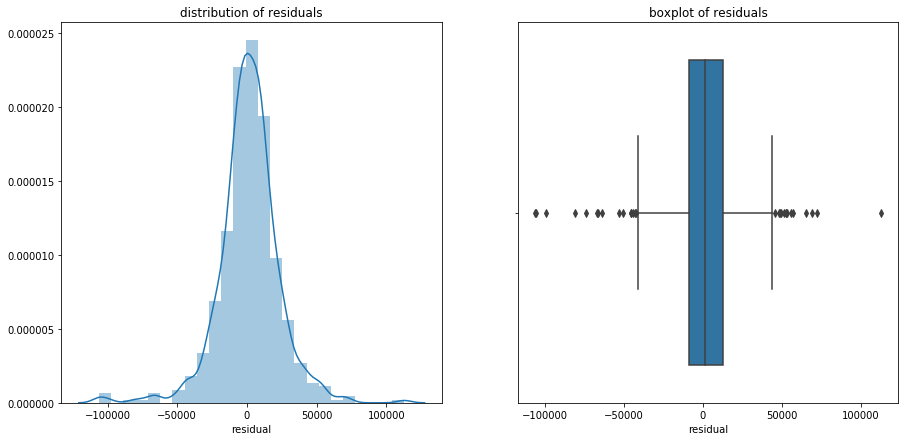

In [3924]:
plt.subplots(1,2, figsize=(15,7))

plt.subplot(1,2,1, title='distribution of residuals')
sns.distplot(table['residual'], bins=25, kde=True)

plt.subplot(1,2,2, title='boxplot of residuals')
sns.boxplot(table['residual'])

Text(0,0.5,'residual')

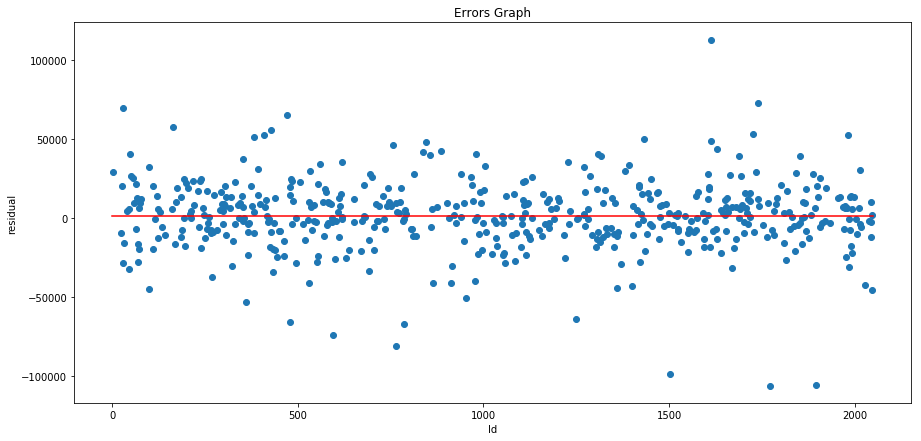

In [3925]:
plt.figure(figsize=(15,7))
plt.scatter(table.index,table['residual'])
plt.plot((0,2050), (np.mean(table['residual']),np.mean(table['residual'])) , c='r')
plt.title('Errors Graph')
plt.xlabel('Id')
plt.ylabel('residual')  # error in calculation


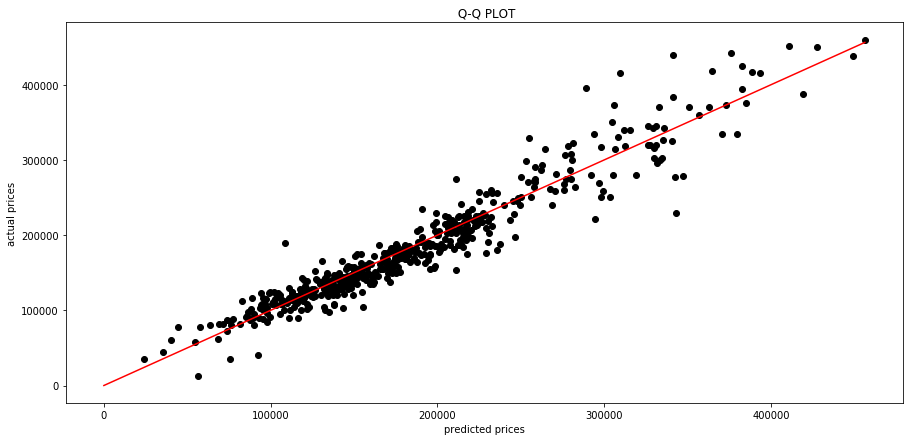

In [3926]:
#QQ
plt.figure(figsize=(15,7))

plt.scatter(Predict_lasso,y_test, c='k')
plt.xlabel('predicted prices')
plt.ylabel('actual prices')
plt.title(' Q-Q PLOT')

plt.plot( [0, np.max(Predict_lasso)], [0, np.max(Predict_lasso)], c = 'r')

# plt.plot( [250000, 0], [250000, 400000], c = 'r')
# plt.plot((0,250000), (250000,400000) , c='r')
